In [ ]:
import os
#os.chdir('/content/drive/MyDrive/invoice data extraction/')
os.listdir()

In [ ]:
#import zipfile
# #with zipfile.ZipFile('/content/drive/MyDrive/invoice data extraction/train3.zip','r') as zipf:
#  zipf.extractall('/content/drive/MyDrive/invoice data extraction/train3')

# Install Packages

In [ ]:
!sudo apt-get install tesseract-ocr
!pip -q install pytesseract
!pip install --user easyocr -q
!pip -q install faiss-cpu
!pip install --upgrade typing_extensions -q
!pip -q install datasets
!pip -q install pillow transformers torch openpyxl
!pip install transformers torchvision -q
!pip install timm -q

In [4]:
from PIL import Image
import os
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, RagRetriever, RagTokenForGeneration
from datasets import Dataset
import cv2
import numpy as np

# Data Processing

In [ ]:
image_dir_r = 'train/receipt'
image_dir_i = 'train/invoice'
output_dir = 'structured_data/invoice'  
os.makedirs(output_dir, exist_ok=True)

In [6]:
def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

file_count_i = count_files_in_directory(image_dir_i)
file_count_r = count_files_in_directory(image_dir_r)
print(f"Number of invoice images: {file_count_i}")
print(f"Number of invoice receipt: {file_count_r}")

Number of invoice images: 2700
Number of invoice receipt: 2694


## Image Processing

In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at path: {image_path}")
        return None

    h, w = img.shape[:2]
    scale = max(400 / h, 400 / w)
    if scale > 1:
        img = cv2.resize(img, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_CUBIC)

    img = cv2.GaussianBlur(img, (3, 3), 0)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast = clahe.apply(gray)

    coords = np.column_stack(np.where(contrast > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    if 1.5 <= abs(angle) <= 15:
        (h, w) = contrast.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        contrast = cv2.warpAffine(contrast, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    thresh = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(np.vstack(contours))
        cropped = contrast[y:y + h, x:x + w]
    else:
        cropped = contrast

    return cropped


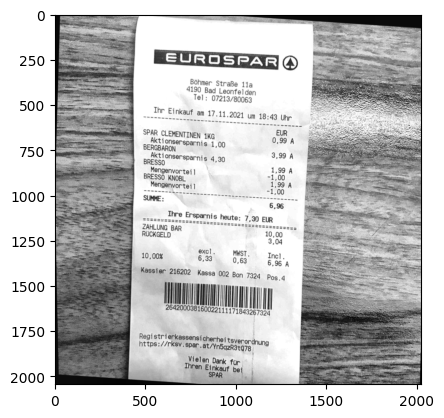

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import torch
import numpy as np

processor = DetrImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = DetrForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

def detect_tables_table_transformer_from_cv2(cv2_image):
    pil_image = Image.fromarray(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB))
    
    inputs = processor(images=pil_image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([pil_image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.8)[0]

    boxes = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == "table":
            boxes.append(box.detach().cpu().numpy().astype(int))  

    return pil_image, boxes

c:\Users\Welcome\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
You are using a model of type table-transformer to instantiate a model of type detr. This is not supported for all configurations of models and can yield errors.
c:\Users\Welcome\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Welcome\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This 

In [ ]:
def get_cropped_tables_from_cv2_image(cv2_image):
    image_pil, table_boxes = detect_tables_table_transformer_from_cv2(cv2_image)

    cropped_tables = []
    for (x1, y1, x2, y2) in table_boxes:
        cropped = image_pil.crop((x1, y1, x2, y2))
        cropped_tables.append(cropped)
    
    return cropped_tables

In [19]:
import matplotlib.pyplot as plt

preprocessed_image = preprocess_image('train/invoice/26_png_jpg.rf.2318e3f83a44413b5b855925e571a538.jpg')
cropped_table_images = get_cropped_tables_from_cv2_image(preprocessed_image)

cor: []


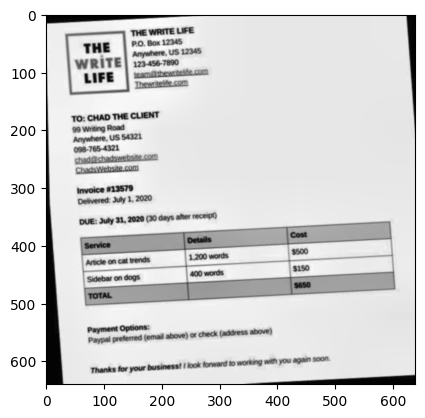

In [21]:
plt.imshow(preprocessed_image, cmap='gray')  
plt.show()

## Test extraction

### pytesseract

In [ ]:
# Text extraction from images using pytesseract
"""
def extract_text_from_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
    extracted_data = []
    count = 0
    for image_file in image_files:
        print(image_file)
        image_path = os.path.join(image_dir, image_file)
        preprocessed_image = preprocess_image(image_path)
        preprocessed_pil_image = Image.fromarray(preprocessed_image)
        text = pytesseract.image_to_string(preprocessed_pil_image, lang='eng').strip()
        extracted_data.append({'image_file': image_file, 'text': text})
        count+=1
        if count==5:
          break
    return extracted_data
"""

#ext2 = extract_text_from_images(image_dir)

### Easyocr

In [26]:
import easyocr
import tempfile

In [27]:
def extract_text_from_cropped_image(cropped_img):
    reader = easyocr.Reader(['en'])
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    cv2.imwrite(temp_file.name, cropped_img)

    results = reader.readtext(temp_file.name)
    text = " ".join([result[1] for result in results])

    temp_file.close()
    os.remove(temp_file.name)

    return text

In [28]:
#sample extraction text
ext = extract_text_from_cropped_image(preprocessed_image)
print(ext)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\Welcome\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EUROSRAR Bohmer StraBe Ila 4190 Bad Leonfel den Tel : 07213/80063 Ihr Einkauf am 17.11.2021 Um  18:43 Uhr SPAR_CLEMENTINEN 1KG EUR Aktionsersparni s 1,00 0,99 A BERGBARON Akti onsersparnis 4,30 3,99 A BRESSO Mengenvortei 1 1,99 A BRESSO KNOBL 00 Mengenvortei 1 1,99 A -1,00 SUMME: 6,96 Ihre Ersparnis 7,30 EUR 82 ZAHLUNG BAR ==8== RUCKGELD 10 00 3,04 exc] MWST 10,00% 6,33 Inc] . 0,63 6,96 A Kassier 216202 Kassa 002 Bon 7324 Pos. 4 264200038160622111171843287324 Registrierkassensicherhei https: / /rksv. spar _ 'chevhedzeveaagdhung Vielen Dank fur Ihren Einkauf bei SPAR -1,4 heute:


## Text processing


In [10]:
import re

def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text).strip()
    # Remove all characters except alphanumeric, '.', ',', ':', and spaces
    text = re.sub(r'[^a-zA-Z0-9.,: ]', '', text)
    text = text.lower()

    return text

In [33]:
processed_text = preprocess_text(ext)

# GPT 2

In [31]:
import json
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [32]:
# Initialize GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

c:\Users\Welcome\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Welcome\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\Welcome\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_downlo

In [36]:
def generate_table_from_text(extracted_text):
    # Prepare the prompt
    prompt = "Give title and construct table with the following data as JSON:\n" + extracted_text

    # Tokenize and generate text using GPT-2
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(inputs['input_ids'], max_length=1024, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)

    print("prompt given..")
    # Decode the output and extract the JSON
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)
    print("text generated by gpt..")
    try:
        print("structuring text..")
        json_start = generated_text.index('{')
        json_end = generated_text.rindex('}') + 1
        json_data = generated_text[json_start:json_end]
        table_data = json.loads(json_data)  # Convert JSON text to Python dict
    except (ValueError, json.JSONDecodeError):
        print("Error: Generated text does not contain valid JSON.")
        return None

    return table_data


In [37]:
table_data = generate_table_from_text(processed_text)
print(table_data)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


prompt given..
Give title and construct table with the following data as JSON:
eurosrar bohmer strabe ila 4190 bad leonfel den tel : 0721380063 ihr einkauf am 17.11.2021 um 18:43 uhr sparclementinen 1kg eur aktionsersparni s 1,00 0,99 a bergbaron akti onsersparnis 4,30 3,99 a bresso mengenvortei 1 1,99 a bresso knobl 00 mengenvortei 1 1,99 a 1,00 summe: 6,96 ihre ersparnis 7,30 eur 82 zahlung bar 8 ruckgeld 10 00 3,04 exc mwst 10,00 6,33 inc. 0,63 6,96 a kassier 216202 kassa 002 bon 7324 pos. 4 264200038160622111171843287324 registrierkassensicherhei https:  rksv. spar  chevhedzeveaagdhung vielen dank fur ihren einkauf bei spar 1,4 heute: 0.00 1.01 0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 0 9 0 10 0 11 0 12 0 13 0 14 0 15 0 16 0 17 0 18 0 19 0 20 0 21 0 22 0 23 0 24 0 25 0 26 0 27 0 28 0 29 0 30 0 31 0 32 0 33 0 34 0 35 0 36 0 37 0 38 0 39 0 40 0 41 0 42 0 43 0 44 0 45 0 46 0 47 0 48 0 49 0 50 0 51 0 52 0 53 0 54 0 55 0 56 0 57 0 58 0 59 0 60 0 61 0 62 0 63 0 64 0 65 0 66 0 67 0 68 0 69 0 70 

In [ ]:
def save_json_as_csv(table_data, output_file):
    if table_data:
        df = pd.DataFrame(table_data)  # Convert JSON dict to pandas DataFrame
        df.to_csv(output_file, index=False)  # Save DataFrame to CSV
        print(f"Saved structured data to {output_file}")

In [ ]:

print("Extracting text from images...")
extracted_data = [{'image_file': '1000-receipt_jpg.rf.57cc25581e55df4c4e839890fe81ee00.jpg',
  'text': 'GAEEN Fleld T CaciF COas WVN L"no Daach unnnu ano 59(-0906 stulion SuynI Jc!e Dnr 0t os 64974 lueet & Table 45-40 Wacn Coka SuD IQAL: Tox ~ToTal : 456.50 5/26/2016 12.:i0 Fh [HANK\' You ! Ued'}]# extract_text_from_images(image_dir)

print("Processing extracted data with GPT-2 to generate tables...")
for data in extracted_data:
  extracted_text = data['text']
  image_file = data['image_file']

  # Generate structured table as JSON
  table_data = generate_table_from_text(extracted_text)
  print(table_data)
  break

  #if table_data:
  #  output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}.csv")
  #  save_json_as_csv(table_data, output_path)

'\nprint("Extracting text from images...")\nextracted_data = [{\'image_file\': \'1000-receipt_jpg.rf.57cc25581e55df4c4e839890fe81ee00.jpg\',\n  \'text\': \'GAEEN Fleld T CaciF COas WVN L"no Daach unnnu ano 59(-0906 stulion SuynI Jc!e Dnr 0t os 64974 lueet & Table 45-40 Wacn Coka SuD IQAL: Tox ~ToTal : 456.50 5/26/2016 12.:i0 Fh [HANK\' You ! Ued\'}]# extract_text_from_images(image_dir)\n\nprint("Processing extracted data with GPT-2 to generate tables...")\nfor data in extracted_data:\n  extracted_text = data[\'text\']\n  image_file = data[\'image_file\']\n\n  # Generate structured table as JSON\n  table_data = generate_table_from_text(extracted_text)\n  print(table_data)\n  break\n'

# GPT 4 pipeline

In [ ]:
from transformers import pipeline

In [ ]:
gpt_pipeline = pipeline("text-generation", model="nomic-ai/gpt4all-j")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
input_text = "GANTD LTX C3FE RooseveIL Fleld 0480 TABLE 101 #Party STEPHEN SvrCk : \'16:43 04/25/15 Coffee 13.95 Chicken Parmesan Prime rioin 25.95 The Bacon Chelain Burger 13.95 Cotfee Subi Total: 63.75 Tax: Sub Total {69.25 04/25 17;47 TOTAL 6 18 Gratuity Not-Included Suguested Gratuity 203 13.85 18* 12.47 451 been pleasure tO serve You Thank You for dining with Us'}"
prompt = f"Give title to the table and construct a table with the following data, and return the table as JSON:\n\n{input_text}"

response = gpt_pipeline(prompt, max_length=1024, num_return_sequences=1)[0]['generated_text']

response

In [ ]:
def fine_tune_gpt4(extracted_data):
    # Initialize GPT-4 model pipeline (using text generation model from Hugging Face)
    gpt_pipeline = pipeline("text-generation", model="nomic-ai/gpt4all-j")

    structured_data = []

    for data in extracted_data:
        input_text = data['text']
        # Formulate the prompt for table generation
        prompt = f"Give title to the table and construct a table with the following data, and return the table as JSON:\n\n{input_text}"

        # Generate table as JSON using the model
        response = gpt_pipeline(prompt, max_length=1024, num_return_sequences=1)[0]['generated_text']

        structured_data.append({'image_file': data['image_file'], 'structured_json': response})

    return structured_data

In [ ]:
def json_to_csv_and_save(structured_data):
    for data in structured_data:
        json_text = data['structured_json']

        try:
            # Convert the JSON text into a DataFrame
            df = pd.read_json(json_text)

            # Save DataFrame to CSV
            output_path = os.path.join(output_dir, f"{os.path.splitext(data['image_file'])[0]}.csv")
            df.to_csv(output_path, index=False)
            print(f"Saved {output_path}")
        except ValueError:
            print(f"Failed to process JSON for {data['image_file']}")


In [ ]:
print("Extracting text from images...")
extracted_data = extract_text_from_images(image_dir)

Extracting text from images...


In [ ]:
extracted_data

[{'image_file': '1000-receipt_jpg.rf.57cc25581e55df4c4e839890fe81ee00.jpg',
  'text': '3.00\n45 90\n3.00\n\n5190\n060\n\n   \n\n5/26/2016 12-53-10 PM\n\nTHANK You!\n\neee'},
 {'image_file': '1000-receipt_jpg.rf.b17cbc08490974652c2d9086e1e50dca.jpg',
  'text': ''},
 {'image_file': '1001-receipt_jpg.rf.109e88972a60051c211342c57973d540.jpg',
  'text': 'ol\n\nGaRAnNrP Ke\n\npocesvelt heie\nqaeve 100 Sharky\na v8:43\n\nyee\n\nas2s/\n\n   \n \n\n048°\nSTEPHEN F\n\ncoffee\nCotten parses\nOne Top SNTlON\nBr 1s gcon-cneese Pe\ncarter\n\neae'},
 {'image_file': '1001-receipt_jpg.rf.324f4e0a4f5c9ef2a0a2a6857e6c7b51.jpg',
  'text': 'i.\n\nGrRanpPt aK\n\nevelt Feld\n\n \n\n \n\n \n\n \n\n \n\nRoost\naso THEI Mera\nOs R sce: 4 fares 04/25/19\ncoffee. 2.98\nCotten Parmesan 17.38\nCheon sir torn 23.35\nPrime ron cheese Surge 13\ntotfee 2\na totals, 3168\nee\nEen. se\na your" ©\ngravutty Wot SRT\naCe AE\npes. pean 2 PISA to serve YU"\nPleasiining with YS\n\n————'},
 {'image_file': '1001-receipt_jpg.rf.4

In [ ]:
print("Generating structured table using GPT-4...")
structured_data = fine_tune_gpt4(extracted_data)

Generating structured table using GPT-4...


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print("Saving structured data to CSV files...")
json_to_csv_and_save(structured_data)
print("Process completed!")

# GPT4All


In [ ]:
!pip -q install gpt4all

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00


In [ ]:
from gpt4all import GPT4All
model = GPT4All("Meta-Llama-3-8B-Instruct.Q4_0.gguf")

Downloading: 100%|██████████| 4.66G/4.66G [02:11<00:00, 35.5MiB/s]
Verifying: 100%|██████████| 4.66G/4.66G [00:16<00:00, 288MiB/s]


In [ ]:
tex = "GANTD LTX C3FE RooseveIL Fleld 0480 TABLE 101 #Party STEPHEN SvrCk : \'16:43 04/25/15 Coffee 13.95 Chicken Parmesan Prime rioin 25.95 The Bacon Chelain Burger 13.95 Cotfee Subi Total: 63.75 Tax: Sub Total 69.25 04/25 17;47 TOTAL 6 18 Gratuity Not-Included Suguested Gratuity 203 13.85 18* 12.47 451 been pleasure tO serve You Thank You for dining with Us. /n the above text is a invoice bill text extracted using EasyOCR, convert this into to a table and return the table as JSON"

In [ ]:
#sample generation
with model.chat_session():
    print(model.generate(tex, max_tokens=1024))

Here is the converted table in JSON format:

```
{
    "columns": [
        {
            "name": "Item",
            "values": ["GANTD LTX C3FE RooseveIL Fleld 0480 TABLE", "Coffee", "Chicken Parmesan Prime rioin", "The Bacon Chelain Burger", "Cotfee Subi"]
        },
        {
            "name": "Price",
            "values": ["13.95", "25.95", "13.95", "", "12.47"]
        }
    ],
    "data": [
        [GANTD LTX C3FE RooseveIL Fleld 0480 TABLE, 13.95],
        [Coffee, 13.95],
        [Chicken Parmesan Prime rioin, 25.95],
        [The Bacon Chelain Burger, 13.95],
        [Cotfee Subi, 12.47]
    ]
}
```

Note that I had to make some assumptions about the table structure and data based on the provided text. Specifically:

* The first column is assumed to be "Item" with values being the names of menu items.
* The second column is assumed to be "Price" with values being the prices of each item (except for the last row, which appears to be a subtotal or total).
* I did not include 

In [ ]:

def fine_tune_gpt4all(extracted_data):
    structured_data = []

    for data in extracted_data:
        # Define the prompt for GPT-4All
        prompt = f"Give title to the table and construct table with the following data: {data}. Return the table as JSON."

        # Generate the table in JSON format
        with model.chat_session():
          response = model.generate(prompt, max_tokens=1024)

        generated_json = response['choices'][0]['message']['content']

        structured_data.append({
            'image_file': data['image_file'],
            'json_table': generated_json
        })

    return structured_data

In [ ]:
# Step 3: Convert the structured JSON to CSV and save
def save_to_csv(structured_data):
    for data in structured_data:
        json_table = data['json_table']
        image_file = data['image_file']

        # Convert JSON table to a pandas DataFrame
        df = pd.read_json(json_table)

        # Save DataFrame to CSV
        output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}.csv")
        df.to_csv(output_path, index=False)

In [ ]:
print("Extracting text from images...")
extracted_data = extract_text_from_images(image_dir)

Extracting text from images...


In [ ]:
print("Generating structured tables using GPT-4All...")
structured_data = fine_tune_gpt4all(extracted_data)

Generating structured tables using GPT-4All...


In [ ]:
print("Saving structured tables to CSV files...")
save_to_csv(structured_data)
print("Process completed!")